# Predicting Fraud in Financial Payment Services

Trying to recognize and predict fraud in financial transactions is a good example of binary classification analysis. A transaction either is fraudulent, or it is genuine. What makes fraud detection especially challenging is the highly imbalanced distribution between positive (genuine) and negative (fraud) classes. <br><br>
In the analysis we have used a *synthetic* dataset of mobile money transactions. It consists of nearly 6.4 million rows of data divided into five types of transactions; CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. Fraud occurs only in two of them; TRANSFER and CASH_OUT. The number of transactions in these types was almost 2.8 million and the number of fraudulent transactions among them was only 8000, making it a truly skewed set of data!<br><br>
The optimal solution turned out to be a combination of feature-engineering and extreme gradient-boosted decision trees (XGBoost).  We have used Decision Tree Classifier and XGBClassifier to do the predictions. The predictive power of the model is 0.99, as measured by the area under the precision-recall curve (AUPRC). Crucially, these results were obtained without artificial balancing of the data, such as SMOTE (Synthetic Minority Over-sampling Technique), making this approach suitable to real-world applications!

In [3]:
!pip install joblib

     |████████████████████████████████| 307kB 8.1MB/s eta 0:00:01


In [55]:
import json # will be needed for saving preprocessing details
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import joblib

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Downloading and combining the data
The data consists of over 6.3 million rows in csv. Next, data is imported and concatenated into one dataframe.

In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ea62c42fd3654f048e5b992fc153c912 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='EuxQ1RRVuV7Gvxza_cXe78Bl6YLv1Mi4UPAjFoKyYu7u',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_ea62c42fd3654f048e5b992fc153c912.get_object(Bucket='frauddetection-donotdelete-pr-zwzeoasjdttgo9',Key='PS_20174392719_1491204439457_log.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

Correct minor spelling errors in original column headers for consistency.

In [4]:
df = df.rename(columns={'oldbalanceOrg':'OldBalanceOrig', 'newbalanceOrig':'NewBalanceOrig', \
                        'oldbalanceDest':'OldBalanceDest', 'newbalanceDest':'NewBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  OldBalanceOrig  NewBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  OldBalanceDest  NewBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
OldBalanceOrig    float64
NewBalanceOrig    float64
nameDest           object
OldBalanceDest    float64
NewBalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## Adjusting datatypes 
All columns were of datatype *object*, so some need to be changed into floats and integers in order to be able to make calculations with them.

In [6]:
df["step"] = df.step.astype(str).astype(int) 
df["amount"] = df.amount.astype(str).astype(float) 
df["OldBalanceOrig"] = df.OldBalanceOrig.astype(str).astype(float)
df["NewBalanceOrig"] = df.NewBalanceOrig.astype(str).astype(float)
df["OldBalanceDest"] = df.OldBalanceDest.astype(str).astype(float)
df["NewBalanceDest"] = df.NewBalanceDest.astype(str).astype(float)
df["isFraud"] = df.isFraud.astype(str).astype(int)

In [7]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
OldBalanceOrig    float64
NewBalanceOrig    float64
nameDest           object
OldBalanceDest    float64
NewBalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Next, testing if any missing values are there in the dataframe.

In [8]:
df.isnull().values.any()

False

## Pointing out the fraudulent transaction
There are five types of transactions; CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. Fraud occurs only in two of them: 
- 'TRANSFER' where money is sent to a customer / fraudster 
- 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash <br><br>
Among all the 6.4mio transactions, including 2.8mio of TRANSFERs and CASH_OUTs, how many are frauds, i.e. has value '1' in the 'isFraud' column.

In [9]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer))) # 4097
print ('\n The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


Next, the needed explanatory variables are assembled. Irrelevant columns *nameOrig, nameDest* and *isFlaggedFraud* are deleted.

Since fraud only occurs in 'TRANSFER's and 'CASH_OUT's, then only these two are needed as X:s for the analysis.

In [10]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
randomState = 42
np.random.seed(randomState)
Y = X['isFraud']
del X['isFraud']   
# Eliminate columns shown to be irrelevant for analysis 
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

Binary-encoding of labelled data; the two cases where fraud occurs are labelled separately.

In [11]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 7 columns):
step              int64
type              int64
amount            float64
OldBalanceOrig    float64
NewBalanceOrig    float64
OldBalanceDest    float64
NewBalanceDest    float64
dtypes: float64(5), int64(2)
memory usage: 169.1 MB


## Further data pattern analysis
Can any patterns be discovered from comparing the various combinations of balances? To find that -
<br>
First, comparing the recipients's balances before and after a transaction.
### a) Both the old and new balance in the *recipient´s* account were zero, but transferred amount was *not* zero:

In [13]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

print('\nThe percentage of \'fraudulent\' transactions where both the old and new balance in the recipient´s account were zero,\
\nbut the transacted amount was not zero: {0:.4%}'.\
format(len(Xfraud.loc[(Xfraud.OldBalanceDest == 0) & \
(Xfraud.NewBalanceDest == 0) & (Xfraud.amount )]) / (1.0 * len(Xfraud))))

print('\nThe percentage of \'genuine\' transactions where both the old and new balance in the recipient´s account were zero,\nbut the transacted amount was zero: {0:.4%}'.\
format(len(XnonFraud.loc[(XnonFraud.OldBalanceDest == 0) & \
(XnonFraud.NewBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The percentage of 'fraudulent' transactions where both the old and new balance in the recipient´s account were zero,
but the transacted amount was not zero: 49.5556%

The percentage of 'genuine' transactions where both the old and new balance in the recipient´s account were zero,
but the transacted amount was zero: 0.0618%


Next, comparing the sender's balances before and after a transaction.
### b) Both the old and new balance in the *sender´s* account were zero, but transferred amount was *not* zero:

In [14]:
print('\nThe percentage of \'fraudulent\' transactions where both the old and new balance in the sender´s account were zero, \
\nbut the transacted amount was not zero: {0:.4%}'.\
format(len(Xfraud.loc[(Xfraud.OldBalanceOrig == 0) & \
(Xfraud.NewBalanceOrig == 0) & (Xfraud.amount)])  / (1.0 * len(Xfraud))))

print('\nThe percentage of \'genuine\' transactions where both the old and new balance in the sender´s account were zero, \
\nbut the transacted amount was zero: {0:.4%}'.\
format(len(XnonFraud.loc[(XnonFraud.OldBalanceOrig == 0) & \
(XnonFraud.NewBalanceOrig == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The percentage of 'fraudulent' transactions where both the old and new balance in the sender´s account were zero, 
but the transacted amount was not zero: 0.3044%

The percentage of 'genuine' transactions where both the old and new balance in the sender´s account were zero, 
but the transacted amount was zero: 47.3732%


There seems to be a pattern:<br> 

a) Funds are transferred, but still the *recipient's* balance before and after is zero. Almost 50% of such transcations were fraudulent. For genuine transactions, the *recipient's* balance before and after was zero only in 0.06% of the cases.<br>

b) Funds are transferred, but still the *sender's* balance before and after is zero. Only 0.3% of such transcations were fraudulent. For genuine transactions, the *sender's* balance before and after was zero only in 47 % of the cases.

In summary, zero balances in both *sender's* and *recipient's* accounts are strong indicators of fraud, when the transaction is non-zero. To make use of this discovery in the machine learning algorithm detecting fraud, the balance values of zero are replaced by -1 and -2, respectively. These will make fraudulent transactions stand out, since keeping their values as zeros would make them all appear as genuine.

In [15]:
X.loc[(X.OldBalanceOrig == 0) & (X.NewBalanceOrig == 0) & (X.amount != 0), ['OldBalanceOrig', 'NewBalanceOrig']] = -1

In [16]:
X.loc[(X.OldBalanceDest == 0) & (X.NewBalanceDest == 0) & (X.amount != 0), ['OldBalanceDest', 'NewBalanceDest']] = - 2

In [17]:
X.head()

step  type     amount  OldBalanceOrig  NewBalanceOrig  OldBalanceDest  \
2      1     0     181.00           181.0             0.0            -2.0   
3      1     1     181.00           181.0             0.0         21182.0   
15     1     1  229133.94         15325.0             0.0          5083.0   
19     1     0  215310.30           705.0             0.0         22425.0   
24     1     0  311685.89         10835.0             0.0          6267.0   

    NewBalanceDest  
2            -2.00  
3             0.00  
15        51513.44  
19            0.00  
24      2719172.89

## Feature engineering
In order to utilize the discovery of zero-balances serving to differentiate between fraudulent and genuine transactions, two new features (columns) are created. These record errors in the senders' and receivers' accounts for each transaction. <br><br>
[It turned out in the analysis below, that these new features became important in high-lighting the fraudulent transactions. This is especially apparent in viewing the results in a 3D-chart]

In [18]:
X['ErrorBalanceOrig'] = X.NewBalanceOrig + X.amount - X.OldBalanceOrig 
X['ErrorBalanceDest'] = X.OldBalanceDest + X.amount - X.NewBalanceDest

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 9 columns):
step                int64
type                int64
amount              float64
OldBalanceOrig      float64
NewBalanceOrig      float64
OldBalanceDest      float64
NewBalanceDest      float64
ErrorBalanceOrig    float64
ErrorBalanceDest    float64
dtypes: float64(7), int64(2)
memory usage: 211.4 MB


## Data visualization
The best way of confirming that the data contains enough information so that a Machine Learning algorithm can make strong predictions is to try and directly visualize the differences between fraudulent and genuine transactions. Motivated by this principle, these differences are visualized in several ways in the plots below.

In [20]:
limit = len(X) # Altogether 2770409 transactions of TRANSFERs and CASH_OUTs
print(limit)
def plotStrip(x, y, hue, figsize = (16, 8)): 
    fig = plt.figure(figsize = figsize)
    colours = "seismic" 
    with sns.axes_style('whitegrid'):
        ax = sns.stripplot(x, y, hue = hue, jitter = 0.4,  marker = '.', size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize = 16);
    return ax

2770409


### Dispersion over time

Since this is a synthetic dataset, the first column, i.e. *step*, represents an hour of simulations. Altogether, there are 743 steps in the data, meaning it consists of 743 hours of simulated transactions. With the almost 6.4 million transactions, this gives an average of over 8500 transactions per hour in the data.<br><br>
The plot below shows how the fraudulent and genuine transactions are scattered when viewed over time. It is clear that fradulent transactions are more evenly distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. <br>
To make the graph readable and clearer, Seaborn's 'jitter' parameter in stripplot is used in order to widen the visual distribution. Without it, all spots would be crammed together in a narrow, vertical bar.<br><br>
**Why are the genuine transactions grouped into bars with clear gaps in between?** There was no explanation about this in the description of the data. It simply appears that during certain hours there were clearly fewer transactions.

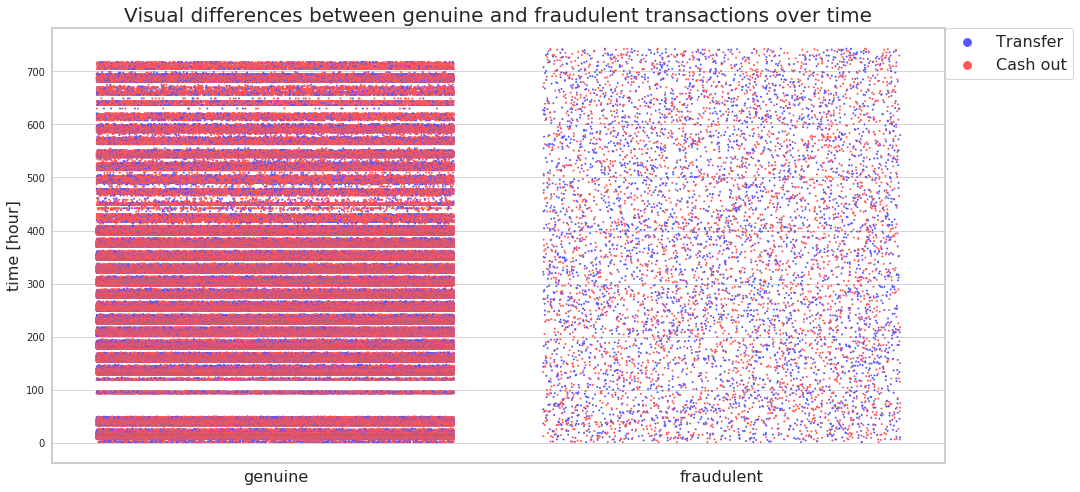

In [21]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])

ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Visual differences between genuine and fraudulent transactions over time', size = 20);

### Dispersion over amount
How well can genuine and fraudulent transactions be separated purely from looking at the sizes of the transactions? Turns out all fraudulent transactions were max 100,000. Yet another indicator for narrowing down the focus on fraud!

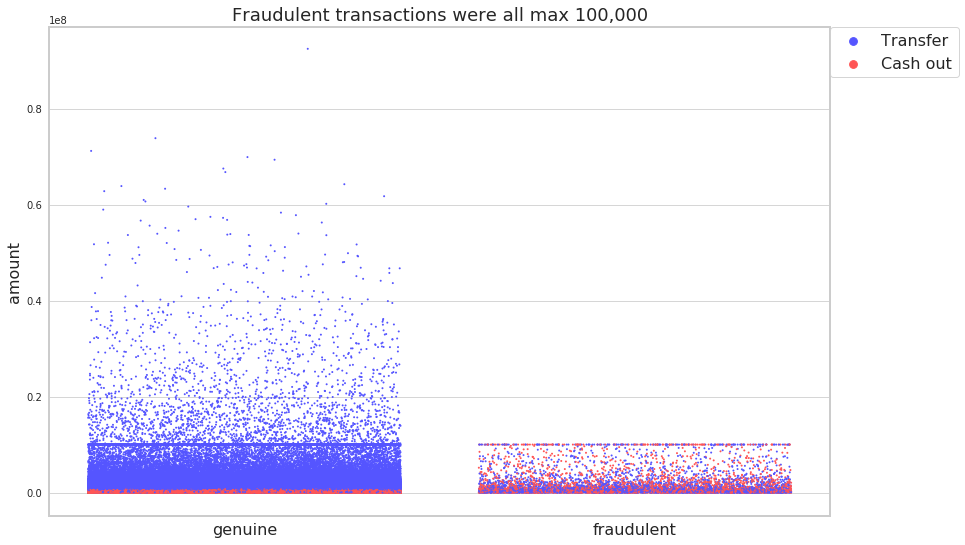

In [22]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Fraudulent transactions were all max 100,000', size = 18);

### Dispersion over error in balance in destination accounts
The new feature 'ErrorBalanceDest' created through feature engineering earlier, also works as a clear visual indicator of fraud. <br><br>
**X['ErrorBalanceDest']** = *X.OldBalanceDest + X.amount - X.NewBalanceDest* <br><br>
Transactions where there is no change in the balances despite money being transferred stand out clearly!


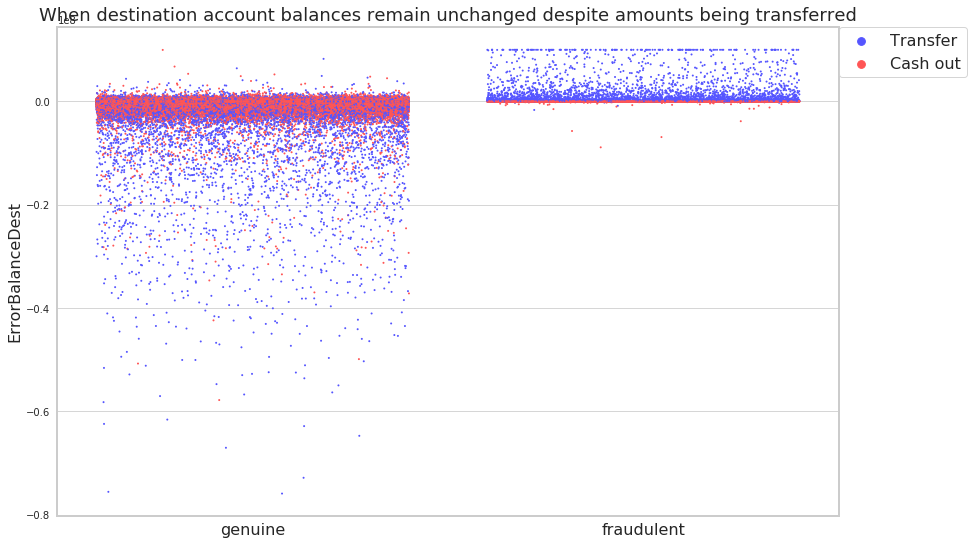

In [23]:
limit = len(X)
ax = plotStrip(Y[:limit], X.ErrorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('ErrorBalanceDest', size = 16)
ax.set_title('When destination account balances remain unchanged despite amounts being transferred', size = 18);

### Separating out genuine from fraudulent transactions
The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step/hour feature is ineffective in seperating out fraud. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


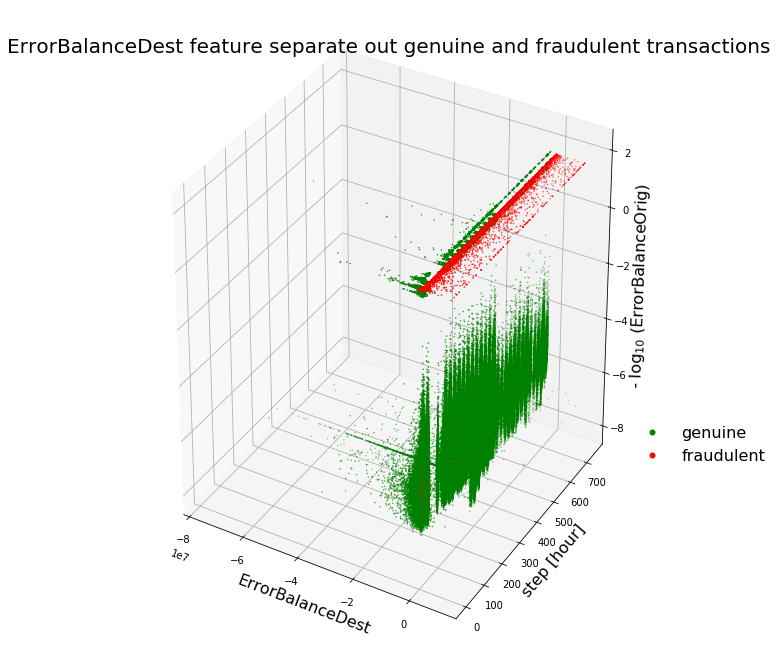

In [24]:
# Long computation in this cell (several minutes)
x = 'ErrorBalanceDest'
y = 'step' 
z = 'ErrorBalanceOrig' 
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('ErrorBalanceDest feature separate out genuine and fraudulent transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

The ErrorBalanceDest feature on the x-axis helps to make fraudulent transactions stand out clearly.
### What's typical for genuine and fraudulent transactions
Comprehensive evidence embedded in the dataset is obtained by examining the correlations between fraudulent and genuine transactions.

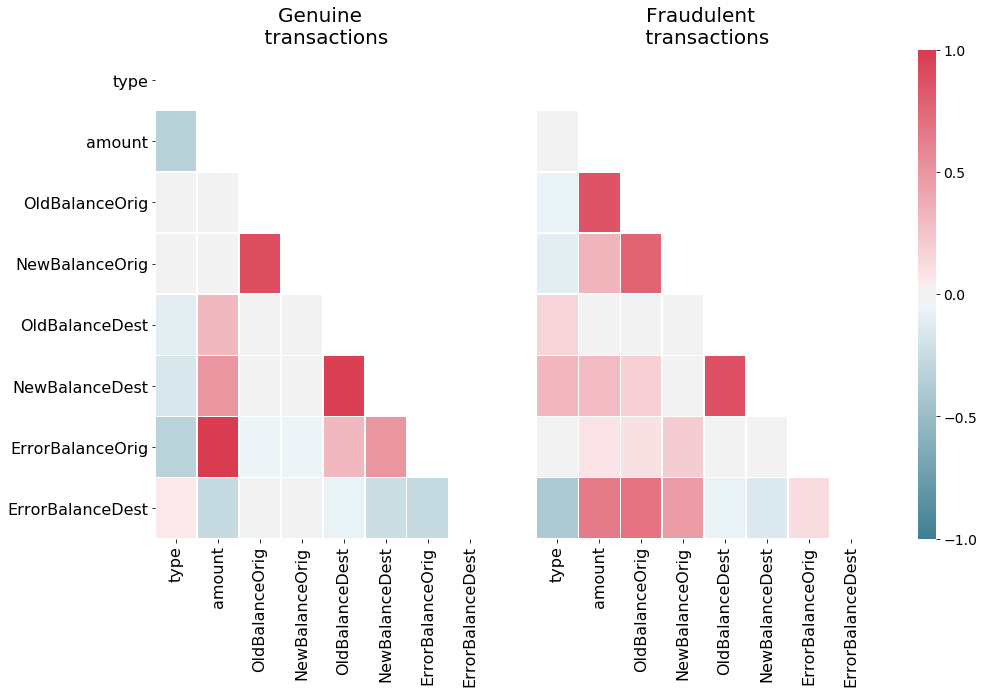

In [25]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

## Machine Learning to Detect Fraud in Skewed Data
Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data. Checking out the skewness gives clear evidence of this!

In [26]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


# XGBClassifier

Next , making the train/test split; 80/20. 

In [27]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

## Building XGBClassifier Model
Let's create a XGBClassifier model using Scikit-learn.

In [28]:
# Create XGBClassifier object
clf = XGBClassifier()
# Train XGBClassifer
clf = clf.fit(trainX, trainY)
#Predict the response for test dataset
y_pred = clf.predict(testX)

In [29]:
# save preprocessing objects and RF algorithm
joblib.dump(clf, "./xgbclassifier.joblib", compress=True)

['./xgbclassifier.joblib']

## Evaluating the model's Accuracy

In [30]:
# Model Accuracy, how often is the classifier correct?
print("XGBClassifier Accuracy:", accuracy_score(testY, y_pred))

XGBClassifier Accuracy: 0.9999837569168463


## Investigating the AUPRC: Area under Precision-Recall Curve
Selection of metric: Since the data is highly skewed, the area under the precision-recall curve (AUPRC) is used rather than the conventional area under the receiver operating characteristic (AUROC). This is because the AUPRC is apparently more sensitive to differences between algorithms and their parameter settings rather than the AUROC.<br>
The model appears to give a 99% accuracy for predicting fraudulent transactions.

In [31]:
# Long computation in this cell!
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {0:.6f}'.format(average_precision_score(testY, probabilities[:, 1]))) 

AUPRC = 0.996797


The results from AUPRC are confirmed also by the similar results from a few other metrics.
## Confusion Matrix
The number of both False Negatives and False Positives was rather low. Perhaps it's even better in this model to have the FPs outrank the FNs; we rather get more false alarms than letting actual frauds slip through undetected.

In [32]:
from sklearn.model_selection import cross_val_predict
Y_predict = cross_val_predict(clf, trainX, trainY, cv=10)

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(trainY, Y_predict)

array([[2209196,     564],
       [     21,    6546]])

## Precision and Recall
Results below indicate that when trying to detect fraudulent transactions:<br>
When it claims a transaction is fraudulent it's correct 92% of the time. However, it does manage to detect 99.7% of thefraudulent transactions.

In [34]:
from sklearn.metrics import precision_score, recall_score
precision_score(trainY, Y_predict)

0.920675105485232

In [35]:
recall_score(trainY, Y_predict)

0.9968021927820923

## F1 score
A harmonic mean of Precision and Recall

In [36]:
from sklearn.metrics import f1_score
f1_score(trainY, Y_predict)

0.957227462162755

## Visualization of ML model
The root node in the decision tree visualized below is indeed the feature errorBalanceOrig, as would be expected from its high significance to the model.

In [37]:
!pip install graphviz

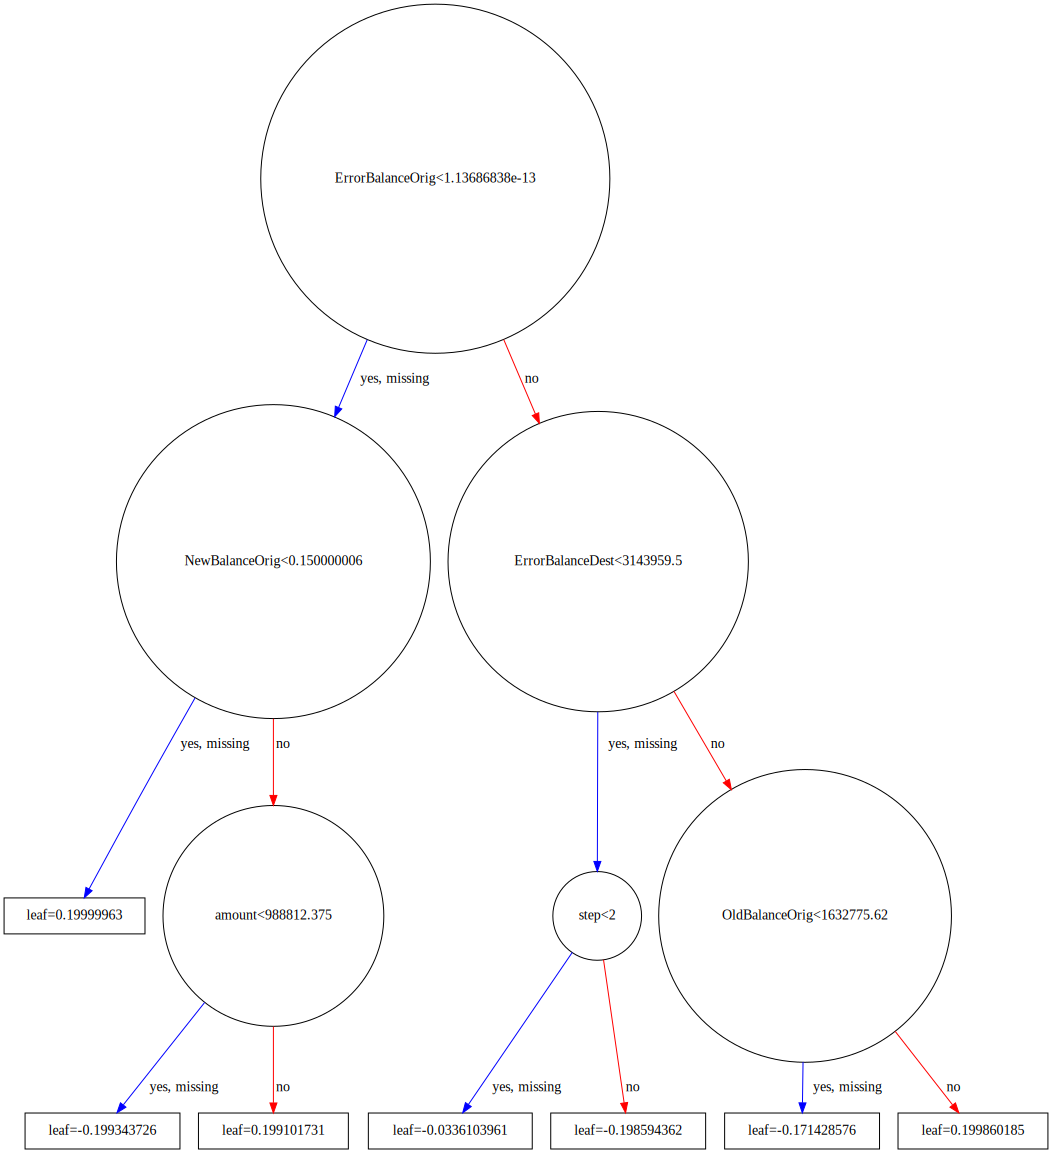

In [38]:
to_graphviz(clf)

## Feature Importance
The figure below shows that the new feature errorBalanceOrig that we created is the most relevant feature for the model. The features are ordered based on the number of samples affected by splits on those features.

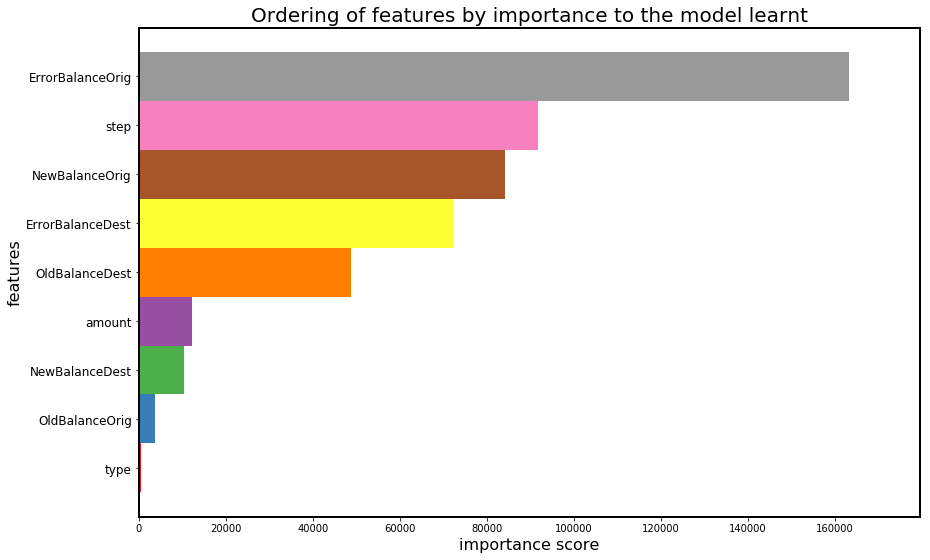

In [39]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

# Decision Tree Classifier

## Feature Selection
Here, the given columns are divided into two types of variables dependent(or target variable) and independent variable(or feature variables).

In [40]:
#split dataset in features and target variable
feature_cols = ['amount', 'OldBalanceOrig', 'NewBalanceOrig','OldBalanceDest','NewBalanceDest','isFlaggedFraud']
X = df[feature_cols] # Features
y = df.isFraud # Target variable

## Splitting Data
To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Let's split the dataset by using function train_test_split() by passing 3 parameters X, y and test_set size.

In [41]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomState) # 70% training and 30% test

## Building a Decision Tree Model
Let's create a Decision Tree Model using Scikit-learn.

In [42]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [43]:
joblib.dump(clf, "./decision_tree.joblib", compress=True)

['./decision_tree.joblib']

## Evaluating Model
To estimate, how accurately the classifier or model can predict the type of transactions as genuine and fraudulent we are computing accuracy of the model.

Accuracy can be computed by comparing actual test set values and predicted values.

In [44]:
# Model Accuracy, how often is the classifier correct?
print("Decision Tree Accuracy:",accuracy_score(y_test, y_pred))

Decision Tree Accuracy: 0.9996503012909776


Well, you got a classification rate of 99.96%, which can be considered as a good accuracy score. 

## Investigating the AUPRC: Area under Precision-Recall Curve
Selection of metric: Since the data is highly skewed, the area under the precision-recall curve (AUPRC) is used rather than the conventional area under the receiver operating characteristic (AUROC). This is because the AUPRC is apparently more sensitive to differences between algorithms and their parameter settings rather than the AUROC.<br>
The model appears to give a 99.96% accuracy for predicting fraudulent transactions using Decision Tree Classifier.

In [45]:
probabilities = clf.predict_proba(X_test)
print('AUPRC = {0:.6f}'.format(average_precision_score(y_test, probabilities[:, 1]))) 

AUPRC = 0.745006


## Confusion Matrix
The number of both False Negatives and False Positives was rather low. Perhaps it's even better in this model to have the FPs outrank the FNs; we rather get more false alarms than letting actual frauds slip through undetected.

In [46]:
from sklearn.model_selection import cross_val_predict
Y_predict = cross_val_predict(clf, X_train, y_train, cv=10)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, Y_predict)

array([[5082673,     830],
       [    938,    5655]])

## Precision and Recall
Results below indicate that when trying to detect fraudulent transactions:<br>
When it claims a transaction is fraudulent it's correct 87% of the time. However, it does manage to detect 85% of thefraudulent transactions.

In [48]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, Y_predict)

0.8720123361603701

In [49]:
recall_score(y_train, Y_predict)

0.8577278932200819

## F1 score

In [50]:
from sklearn.metrics import f1_score
f1_score(y_train, Y_predict)

0.8648111332007952

## Visualizing Decision Trees
We used Scikit-learn's export_graphviz function to display the tree. For plotting tree, you also need to install graphviz and pydotplus.

pip install graphviz

pip install pydotplus

export_graphviz function converts decision tree classifier into dot file and pydotplus convert this dot file to png or displayable form on Jupyter notebook.

In [51]:
!pip install pydotplus

     |████████████████████████████████| 286kB 7.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [52]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('frauds.png')
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.332174 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.332174 to fit



## Bias-variance tradeoff
The model that has been taught has a degree of bias and is slighly underfit. This is indicated by the levelling in AUPRC as the size of the training set is increased in the cross-validation curve below. The easiest way to improve the performance of the model still further is to increase the max_depth parameter of the XGBClassifier at the expense of the longer time spent learning the model. 

In [53]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


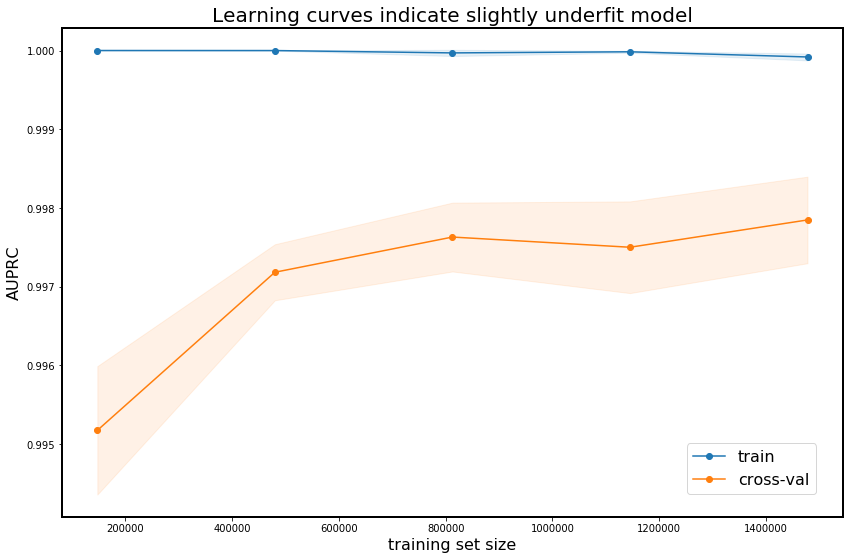

In [54]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9)) #"seismic" 

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

## Conclusion
We thoroughly interrogated the data at the outset to gain insight into which features could be discarded and those which could be valuably engineered. The plots provided visual confirmation that the data could be indeed be discriminated with the aid of the new features. To deal with the large skew in the data, an appropriate metric turned out to be AUPRC and the XGBoost Machine Learning algorithm, which seems to work well with strongly imbalanced classes. The method used in this kernel should therefore be broadly applicable to a range of such problems.